## This notebook tends to replicate the paper "Evaluating scaled windowed variance methods for estimating the Hurst coefficient of time series"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class ScaledWindowedVariance:
    def __init__(self, data, min_window=2, max_window=None):
        self.data = data
        self.n = len(data)
        self.min_window = min_window
        if max_window is None:
            self.max_window = self.n // 2
        else:
            self.max_window = max_window

    def _compute_windows(self, window_size):
        """Divide data into non-overlapping windows of given size."""
        return [self.data[i:i + window_size] 
                for i in range(0, self.n, window_size)
                if i + window_size <= self.n]

    def _detrend_linear(self, window):
        """Remove linear trend from window using regression."""
        x = np.arange(len(window))
        slope, intercept = np.polyfit(x, window, 1)
        trend = slope * x + intercept
        return window - trend

    def _detrend_bridge(self, window):
        """Remove bridge trend from window."""
        if len(window) < 2:
            return window
        x = np.arange(len(window))
        first, last = window[0], window[-1]
        trend = np.linspace(first, last, len(window))
        return window - trend

    def _compute_exclusions(self, method):
        """Compute optimal window exclusions based on series length and method."""
        L = np.log2(self.n)  # Number of window sizes
        if method == 'standard':
            exclude_small = int(L / 5)
            exclude_large = int(2 * L / 5)
        elif method == 'linear':
            exclude_small = int(L / 3)
            exclude_large = int(L / 4)
        elif method == 'bridge':
            exclude_small = int(L / 5)
            exclude_large = int(L / 3)
        else:
            exclude_small = 0
            exclude_large = 0
        return exclude_small, exclude_large

    def estimate_hurst(self, method='standard', auto_exclude=True):
        """
        Estimate Hurst coefficient using scaled windowed variance with optimal window exclusion.
        
        Parameters:
        - method: 'standard', 'linear', or 'bridge'
        - auto_exclude: Whether to automatically compute exclusions based on series length
        
        Returns:
        - Hurst coefficient estimate
        """
        # Generate window sizes
        window_sizes = np.arange(self.min_window, self.max_window + 1, 2)
        
        # Compute optimal exclusions if requested
        if auto_exclude:
            exclude_small, exclude_large = self._compute_exclusions(method)
        else:
            exclude_small, exclude_large = 0, 0
            
        # Apply exclusions
        if exclude_small:
            window_sizes = window_sizes[exclude_small:]
        if exclude_large:
            window_sizes = window_sizes[:-exclude_large]
            
        # Compute log-log regression
        log_sd = []
        log_n = []
        
        for n in window_sizes:
            if n > self.n:
                continue
            windows = self._compute_windows(n)
            if method == 'linear':
                windows = [self._detrend_linear(w) for w in windows]
            elif method == 'bridge':
                windows = [self._detrend_bridge(w) for w in windows]
            
            sd = [np.std(w) for w in windows]
            avg_sd = np.mean(sd)
            log_sd.append(np.log(avg_sd))
            log_n.append(np.log(n))
        
        if not log_sd or not log_n:
            return 0.0
        
        # Linear regression
        log_sd = np.array(log_sd)
        log_n = np.array(log_n)
        A = np.vstack([log_n, np.ones(len(log_n))]).T
        m, _ = np.linalg.lstsq(A, log_sd, rcond=None)[0]
        return m

    def plot_exclusions(self, method='standard'):
        """Visualize window size exclusions for the given method."""
        exclude_small, exclude_large = self._compute_exclusions(method)
        window_sizes = np.arange(self.min_window, self.max_window + 1, 2)
        excluded_small = window_sizes[:exclude_small]
        excluded_large = window_sizes[-exclude_large:] if exclude_large > 0 else []
        
        plt.figure(figsize=(10, 6))
        plt.plot(window_sizes, label='Included Windows')
        plt.plot(excluded_small, label='Excluded Small Windows', linestyle='--', color='red')
        plt.plot(excluded_large, label='Excluded Large Windows', linestyle='--', color='green')
        plt.xlabel('Window Size')
        plt.ylabel('Count')
        plt.title(f'Window Size Exclusions for {method.capitalize()} Method')
        plt.legend()
        plt.show()

Estimated Hurst coefficient (auto_exclude=True): 1.5311725198519162
Estimated Hurst coefficient (manual exclusion): nan


/var/folders/vk/z0p4r5z97d99dp7mpbt9yd1w0000gn/T/ipykernel_44657/3706159750.py:94: RuntimeWarning: divide by zero encountered in log
  log_sd.append(np.log(avg_sd))


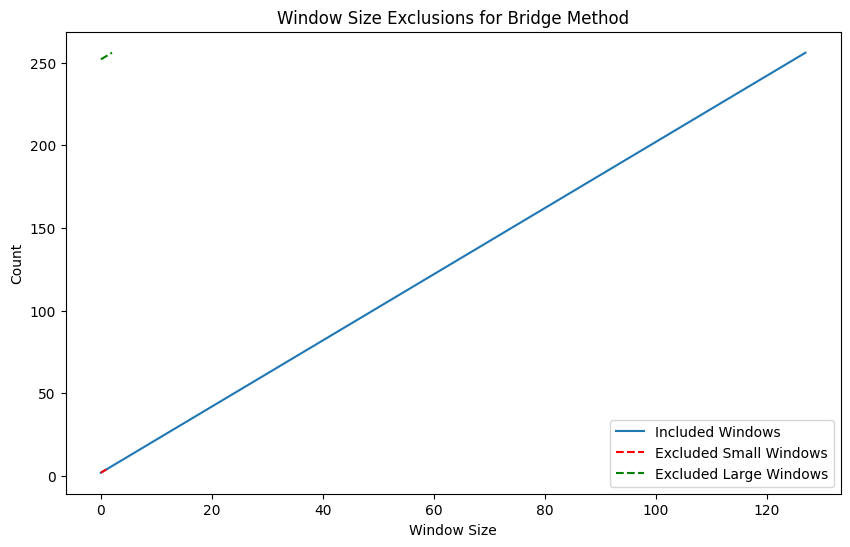

In [2]:
# Generate a sample fBm signal
np.random.seed(42)
n = 2**10  # Signal length
h_true = 0.7  # True Hurst coefficient
fGn = np.cumsum(np.random.normal(size=n))
fBm = np.cumsum(fGn)

# Initialize the estimator
swv = ScaledWindowedVariance(fBm, min_window=2, max_window=256)

# Estimate Hurst coefficient with automatic window exclusion
h_est_auto = swv.estimate_hurst(method='bridge', auto_exclude=True)
print(f"Estimated Hurst coefficient (auto_exclude=True): {h_est_auto}")

# Estimate Hurst coefficient with manual window exclusion
h_est_manual = swv.estimate_hurst(method='bridge', auto_exclude=False)
print(f"Estimated Hurst coefficient (manual exclusion): {h_est_manual}")

# Visualize window exclusions for the bridge method
swv.plot_exclusions(method='bridge')

Window sizes : [  2   4   8  16  32  64 128 256 512]
Exclusions : 1 - 3
Valid window sizes : [  2   4   8  16  32  64 128 256 512]
Log(valid window sizes) : [0.69314718 1.38629436 2.07944154 2.77258872 3.4657359  4.15888308
 4.85203026 5.54517744 6.23832463]
Filtered x : [1.38629436 2.07944154 2.77258872]
Filtered y : [2.37258313 2.81700995 3.17559926]
Coefficient de Hurst estimé : 0.5792536962395065
Window sizes : [  2   4   8  16  32  64 128 256 512]
Coefficient de Hurst estimé (méthode LD) : 3.4693477736553464
Window sizes : [  2   4   8  16  32  64 128 256 512]
Coefficient de Hurst estimé (méthode BD) : nan


/var/folders/vk/z0p4r5z97d99dp7mpbt9yd1w0000gn/T/ipykernel_44657/3161372581.py:100: RuntimeWarning: divide by zero encountered in log
  y = np.log(avg_sds)


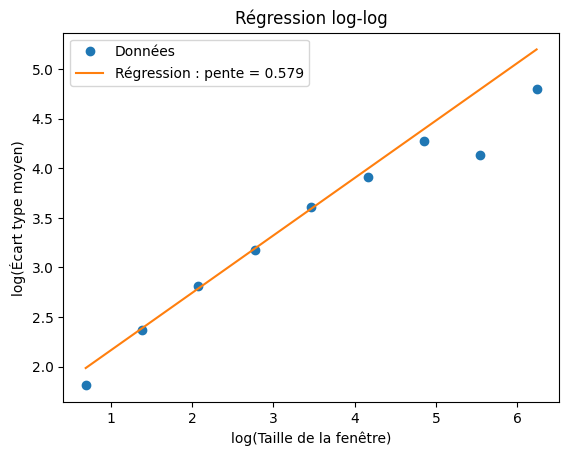

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def linear_detrend(window):
    """
    Détendage linéaire (LD) : ajuste une droite aux données de la fenêtre et
    soustrait la tendance.
    """
    n = len(window)
    t = np.arange(n)
    # Ajustement d'une droite : f(t) = a*t + b
    p = np.polyfit(t, window, 1)  # p[0] = pente, p[1] = intercept
    trend = np.polyval(p, t)
    return window - trend

def bridge_detrend(window):
    """
    Détendage par bridge (BD) : soustrait la droite reliant le premier et le dernier
    point de la fenêtre.
    """
    n = len(window)
    t = np.arange(n)
    start = window[0]
    end = window[-1]
    # Calcul de la droite reliant le premier et le dernier point
    trend = start + (end - start) * t / (n - 1)
    return window - trend

def _compute_exclusions(method, L):
    """Compute optimal window exclusions based on series length and method."""
    if method is None:
        exclude_small = int(L / 5)
        exclude_large = int(2 * L / 5)
    elif method == 'LD':
        exclude_small = int(L / 3)
        exclude_large = int(L / 4)
    elif method == 'BD':
        exclude_small = int(L / 5)
        exclude_large = int(L / 3)
    return exclude_small, exclude_large
    
def estimate_hurst(signal, method=None, auto_exclude=True):
    """
    Estime le coefficient de Hurst H à partir d'un signal en utilisant la méthode
    de la variance fenêtrée (scaled windowed variance).

    Paramètres :
      - signal : tableau 1D (numpy.array) représentant le signal.
      - method : méthode de détendage, 'LD' pour Linear Detrended, 'BD' pour Bridge Detrended.
      
    Retourne :
      - estimated_H : estimation du coefficient de Hurst (la pente de la régression log-log).
      - window_sizes : tailles de fenêtres utilisées.
      - avg_sds : écart type moyen calculé pour chaque taille de fenêtre.
      - slope, intercept : paramètres de la régression linéaire log-log.
    """
    N = len(signal)
    # Choix des tailles de fenêtres : ici, de 2 à N//2 avec un pas de 2.
    # (On peut ajuster ce choix en fonction de la série et des recommandations.)
    window_sizes = 2 ** np.arange(1, int(np.log2(N)) + 1)
    print(f"Window sizes : {window_sizes}")
    
    avg_sds = []            # Liste pour stocker l'écart type moyen pour chaque taille de fenêtre
    valid_window_sizes = [] # On ne retient que les tailles pour lesquelles la division est possible
    
    # Pour chaque taille de fenêtre n
    for n in window_sizes:
        num_windows = N // n  # Nombre de fenêtres non chevauchantes
        if num_windows < 1:
            continue
        sds = []  # Liste pour stocker l'écart type de chaque fenêtre
        
        # Partitionnement du signal en fenêtres de taille n
        for i in range(num_windows):
            window = signal[i * n:(i + 1) * n]
            # Appliquer le détendage en fonction de la méthode choisie
            if method is None:
                detrended = window
            elif method.upper() == 'LD':
                detrended = linear_detrend(window)
            elif method.upper() == 'BD':
                detrended = bridge_detrend(window)
            # Calcul de l'écart type dans la fenêtre (utilisation du ddof=0 pour la population)
            sd = np.std(detrended, ddof=0)
            sds.append(sd)
        # Moyenne des écarts types sur toutes les fenêtres de taille n
        avg_sd = np.mean(sds)
        avg_sds.append(avg_sd)
        valid_window_sizes.append(n)
    
    
    valid_window_sizes = np.array(valid_window_sizes)
    avg_sds = np.array(avg_sds)


    
    # Régression linéaire sur l'échelle log-log :
    # On part de l'hypothèse que : avg_sd ~ n^H  <=> log(avg_sd) = log(constante) + H * log(n)
    x = np.log(valid_window_sizes)
    y = np.log(avg_sds)

    if auto_exclude:
        # Calcul des exclusions optimales
        exclude_small, exclude_large = _compute_exclusions(method, len(window_sizes))
        print(f"Exclusions : {exclude_small} - {exclude_large}")
        print(f"Valid window sizes : {valid_window_sizes}")
        print(f"Log(valid window sizes) : {x}")
        # Filter x based on exclusion criteria
        mask = (x >= exclude_small) & (x <= exclude_large)
        x = x[mask]
        y = y[mask]

        print(f"Filtered x : {x}")
        print(f"Filtered y : {y}")
    
    slope, intercept = np.polyfit(x, y, 1)
    estimated_H = slope  # La pente correspond au coefficient de Hurst estimé.
    
    return estimated_H, valid_window_sizes, avg_sds, slope, intercept

# Exemple d'utilisation
if __name__ == '__main__':
    import pandas as pd
    import numpy as np
    import sys
    sys.path.append('..')
    from src.utils import get_config, get_data
    from src.ext.HurstIndexSolver import HurstIndexSolver

    config = get_config()
    
    # Chargement des données
    ftse100 = get_data('ftse100')

    signal = ftse100.iloc[:1000].values

    # Estimation avec la méthode LD
    H_estimated, ws, avg_sds, slope, intercept = estimate_hurst(signal, auto_exclude=True)
    print("Coefficient de Hurst estimé :", H_estimated)

    # Estimation avec la méthode LD
    H_estimated_LD, ws_LD, avg_sds_LD, slope_LD, intercept_LD = estimate_hurst(signal, method='LD', auto_exclude=False)
    print("Coefficient de Hurst estimé (méthode LD) :", H_estimated_LD)
    
    # Estimation avec la méthode BD
    H_estimated_BD, ws_BD, avg_sds_BD, slope_BD, intercept_BD = estimate_hurst(signal, method='BD', auto_exclude=False)
    print("Coefficient de Hurst estimé (méthode BD) :", H_estimated_BD)
    
    # Visualisation de la régression log-log pour la méthode LD
    plt.figure()
    plt.plot(np.log(ws), np.log(avg_sds), 'o', label='Données')
    plt.plot(np.log(ws), intercept + slope * np.log(ws), label=f'Régression : pente = {slope:.3f}')
    plt.xlabel('log(Taille de la fenêtre)')
    plt.ylabel('log(Écart type moyen)')
    plt.legend()
    plt.title('Régression log-log')
    plt.show()